# Linear Regression Modeling Guide

## How Linear Regression Works
Linear regression models the relationship between:
- **Independent variables** (features like age, smoking status)
- **Dependent variable** (medical charges) 

By finding coefficients (β) that minimize the sum of squared residuals:
```math
charges = β₀ + β₁(age) + β₂(smoker) + ... + ε
```
## Step-by-Step Implementation
1. Data Preparation
```python
# One-hot encode categorical variables; Skip if it has been done previously
df = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

# Separate features (X) and target (y)
X = df.drop(columns=['charges'])
y = df['charges']
```
2. Train-Test Split with Standardization
- **Why Standardize?**
    - Standardization transforms features to:
        - **Mean = 0**
        - **Standard Deviation = 1**

- **Key Benefits**
    - Fair Feature Comparison: Prevents variables with larger scales (e.g., age 0-100) from dominating those with smaller scales (e.g., BMI 15-40)
    - Model Performance: Critical for distance-based algorithms (regression, SVM, KNN); helps gradient descent converge faster
    - Interpretable Coefficients: Enables direct comparison of feature importance weights

- **Common Standardization Techniques**

    | Technique          | Formula                  | Best For                 |
    |--------------------|--------------------------|--------------------------|
    | **Z-score**        | (x - μ)/σ               | Most regression models   |
    | **Min-Max**        | (x - min)/(max - min)    | Neural networks          |
    | **Robust Scaling** | (x - median)/IQR         | Data with outliers       |

- **Best Practices**
    - Fit Standardizer on Training Data Only: Calculate mean/std from training set; apply same transformation to test set
    - Never Standardize the Target Variable (in regression)
    - Handle New Data: Use saved standardization parameters in production
```python
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split data (80% train, 20% test)
# random_state ensures reproducible splits (sets the seed for shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
```
3. Modeling
```
from sklearn.linear_model import LinearRegression

# Initialize and train model
model = LinearRegression()
model.fit(X_train_scaled, y_train)
```
4. Model Evaluation
Success Criteria:
**R² (Coefficient of Determination):**  
Measures the proportion of variance in the dependent variable explained by the independent variables. R² ranges from 0 to 1; higher values indicate a better fit.

**All VIF < 5:**  
VIF (Variance Inflation Factor) quantifies multicollinearity among features. A VIF below 5 suggests low correlation between predictors, indicating stable and reliable coefficient estimates.
- R² > 0.75
- All VIF < 5
```python
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate R²
y_pred = model.predict(X_test_scaled)
print(f"R² Score: {r2_score(y_test, y_pred):.3f}")

# Check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
print(vif_data)
```
5. Model Interpretation
A. Dollar-Value Conversion (A technique to translate regression coefficients into real-world monetary impact by:Taking raw coefficient values from the model; Converting them to annual USD amounts)
```python
coefficients = pd.DataFrame({
    'feature': X_train.columns,
    'impact': model.coef_,
    'dollar_impact': [f"${x:,.2f}" for x in model.coef_]
})
```
B. Smoking Impact Statement
```python
smoking_effect = coefficients[coefficients['feature'] == 'smoker_yes']
print(f"Smoking increases annual costs by {smoking_effect['dollar_impact'].values[0]}")
```
C. Feature Importance
```python
coefficients['abs_impact'] = np.abs(coefficients['impact'])
print(coefficients.sort_values('abs_impact', ascending=False))
```



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
# Load data
df = pd.read_csv("C:/Users/yoooE/Desktop/insurance.csv")

# Check missing values and data types
print("Missing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)

# 1. Drop rows with any missing values``
df = df.dropna()

# 2. Fill missing numerical values with mean or median
# df['column_name'] = df['column_name'].fillna(df['column_name'].mean())

# 3. Fill missing categorical values with mode
# df['column_name'] = df['column_name'].fillna(df['column_name'].mode()[0])

# 4. Fill all missing values with a constant
# df = df.fillna(0)

#Handle outliers in 'charges' (top 1%) -remove values above 99th percentile
percentile_99 = df['charges'].quantile(0.99)

df_filted = df[df['charges']<= percentile_99]
#print(df_filted)

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Data types:
 age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object


In [5]:
#Split features/target
df = pd.get_dummies(df_filted,columns = ['sex','smoker','region'], drop_first = True)
x = df.drop(columns = ['charges'])
y = df['charges']

In [6]:
#Standardize features
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#split data(80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

#STANDARDIZED
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled = scaler.transform(x_test)


In [7]:
#Train model using linear regression
from sklearn.linear_model import LinearRegression

#initialize and train model
model = LinearRegression()
model.fit(X_train_scaled,y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [10]:
# Evaluate and check R2 and VIF
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

#Calculate R2
y_pred = model.predict(X_test_scaled)
print(f'R^2 score:{r2_score(y_test,y_pred):.3f}')

#check VIT
x_numeric = x_train.select_dtypes(include=[float, int])
x_numeric = sm.add_constant(x_numeric)
vif_data = pd.DataFrame()
vif_data["feature"] = x_numeric.columns
vif_data["VIF"] = [variance_inflation_factor(x_numeric.values, i)
                   for i in range(x_numeric.shape[1])]
print(vif_data)


R^2 score:0.724
    feature        VIF
0     const  32.811560
1       age   1.011983
2       bmi   1.011766
3  children   1.003704


In [14]:
# Model Interpretation
coefficients = pd.DataFrame({
    'feature': x_train.columns,
    'impact':model.coef_,
    'dollar_impact': [f'${x:,.2f} ' for x in model.coef_]
}
)
print(coefficients)

            feature       impact dollar_impact
0               age  3604.501931    $3,604.50 
1               bmi  1847.930422    $1,847.93 
2          children   630.936600      $630.94 
3          sex_male    16.518154       $16.52 
4        smoker_yes  9232.265754    $9,232.27 
5  region_northwest  -230.364482     $-230.36 
6  region_southeast  -509.170506     $-509.17 
7  region_southwest  -466.666475     $-466.67 


In [16]:
# Save model artifacts
import os
import joblib


os.makedirs('../models',exist_ok=True)

# 保存模型和 scaler
joblib.dump(model, '../models/insurance_pricing_model.pkl')
joblib.dump(scaler, '../models/scaler.pkl')

print("\nModel saved for production use!")




Model saved for production use!


## Decision Trees for Medical Cost Prediction
### Why Consider Decision Trees?
| Feature           | Linear Regression         | Decision Tree                |
|-------------------|--------------------------|------------------------------|
| Interpretability  | High (coefficients)      | Moderate (tree paths)        |
| Non-linearity     | Needs feature engineering| Handles automatically        |
| Outliers          | Sensitive                | Robust                       |
| Categorical Vars  | Requires encoding        | Native support               |
### Implementation Steps
1. Data Prep Differences
- No need to standardize features (trees are scale-invariant)
- Handle missing values (trees support np.nan natively)
- Keep categoricals ordinal (label encoding suffices)

2. Model Training
```python
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(
    max_depth=5,       # Control complexity
    min_samples_leaf=50 # Prevent overfitting
)
tree.fit(X_train, y_train)  # No scaling needed
```
3. Key Hyperparameters
| Parameter         | Purpose                  | Insurance Use Case         |
|-------------------|--------------------------|----------------------------|
| max_depth         | Limits tree layers       | 4-6 for interpretability   |
| min_samples_leaf  | Minimum data per leaf    | ≥50 for stable groups      |
| ccp_alpha         | Cost-complexity pruning  | Optimize via CV            |
4. Interpretation Tools
A. Feature Importance
Shows which factors (age, smoking, etc.) most influence costs

```python
pd.DataFrame({
    'feature': X_train.columns,
    'importance': tree.feature_importances_
}).sort_values('importance', ascending=False)
```
B. Tree Visualization
```python
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=X.columns, filled=True)
```
Example path:
Smoker? → Yes → Age ≥ 45 → $28,000
(Concrete pricing rules)

5. Pros/Cons for Insurance
✓ Advantages
- Automatic non-linear pattern detection
- Native interaction effects (e.g., smoking × age)
- Explainable rules for regulators
✗ Limitations
- Tendency to overfit without tuning
- Less precise dollar estimates than regression
- Instability with small data changes

### When to Choose Over Regression
- Non-linear cost relationships exist
- Interaction terms are suspected (e.g., smoking + obesity)
- Interpretable rules are prioritized over exact $ amounts

### Performance Metrics
- Maintain R² > 0.7 (similar to linear regression)
- Monitor MAE (Mean Absolute Error) in dollars
- Use out-of-bag error for stability checks



In [20]:
# Todo: Data Preparation**
df = pd.get_dummies(df_filted,columns = ['sex','smoker','region'], drop_first = True)
x = df.drop(columns = ['charges'])
y = df['charges']

from sklearn.model_selection import train_test_split

#spilit data(80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 42)

In [22]:
# Todo:Model Training
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor(
    max_depth = 5,
    min_samples_leaf = 50
)
tree.fit(x_train,y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,50
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [23]:
# Todo: **Model Evaluation**
pd.DataFrame({
    'feature':x_train.columns,
    'importance': tree.feature_importances_
}
).sort_values('importance', ascending=False)

,feature,importance
4,smoker_yes,0.707915
1,bmi,0.161435
0,age,0.119892
2,children,0.010758
3,sex_male,0.000000
5,region_northwest,0.000000
6,region_southeast,0.000000
7,region_southwest,0.000000


[Text(0.6145833333333334, 0.9166666666666666, 'smoker_yes <= 0.5\nsquared_error = 132496882.893\nsamples = 1059\nvalue = 13023.576'),
 Text(0.3958333333333333, 0.75, 'age <= 42.5\nsquared_error = 35978491.824\nsamples = 844\nvalue = 8482.863'),
 Text(0.5052083333333334, 0.8333333333333333, 'True  '),
 Text(0.20833333333333334, 0.5833333333333334, 'children <= 0.5\nsquared_error = 21225131.117\nsamples = 459\nvalue = 5286.353'),
 Text(0.08333333333333333, 0.4166666666666667, 'age <= 22.5\nsquared_error = 12039005.782\nsamples = 198\nvalue = 3508.593'),
 Text(0.041666666666666664, 0.25, 'squared_error = 2811548.783\nsamples = 90\nvalue = 2082.469'),
 Text(0.125, 0.25, 'bmi <= 28.69\nsquared_error = 16621316.148\nsamples = 108\nvalue = 4697.029'),
 Text(0.08333333333333333, 0.08333333333333333, 'squared_error = 27401735.363\nsamples = 50\nvalue = 5277.764'),
 Text(0.16666666666666666, 0.08333333333333333, 'squared_error = 6786481.11\nsamples = 58\nvalue = 4196.395'),
 Text(0.3333333333333

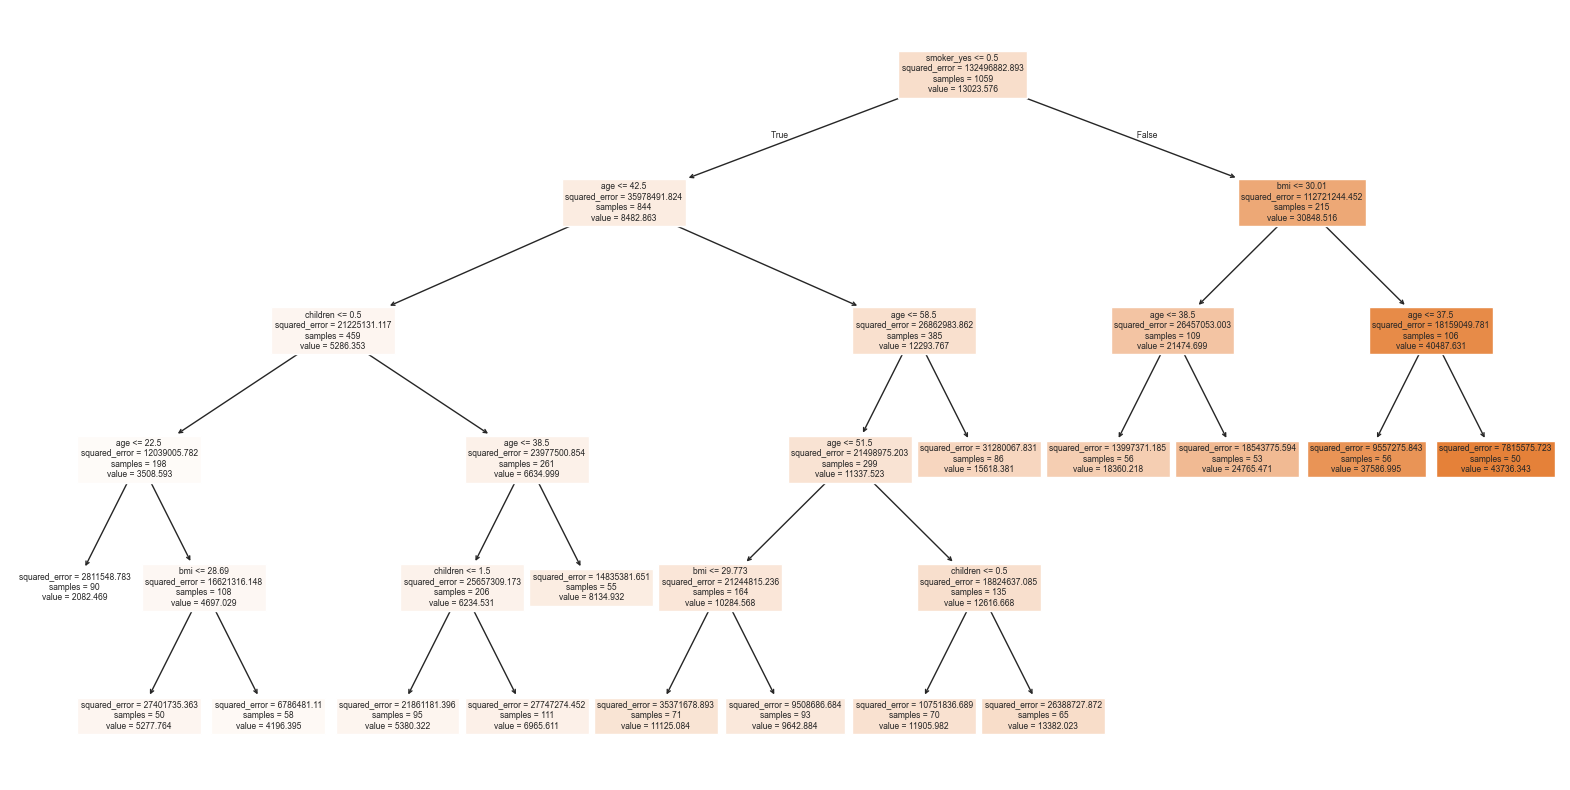

In [26]:
# Todo: **Interpretation**(visualzation)#use same error criterion(task TODO)
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names = x_train.columns, filled=True)

In [25]:
# Todo: 6. **(Optional) Model Saving**
import os
import joblib


os.makedirs('../models_decision',exist_ok=True)

# 保存模型和 scaler
joblib.dump(model, '../models_decision/insurance_pricing_decisiontree_model.pkl')
joblib.dump(scaler, '../models_decision/decisiontree_scaler.pkl')

print("\nModel saved for production use!")



Model saved for production use!


## Alternative ML Models for Medical Cost Prediction (Optional)
| Model                          | Why Use It?                                                                                           | Key Hyperparameters / Implementation Example                                                                                                                                                                                                                                   | Reference                                                                                                                                                                                                                      |
|---------------------------------|-------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Gradient Boosting (XGBoost/LightGBM)** | - Handles non-linear relationships<br>- Captures feature interactions<br>- Robust to outliers        | `from xgboost import XGBRegressor`<br>`model = XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1)`                                                                                                                        | [XGBoost Docs](https://xgboost.readthedocs.io/en/stable/)<br>Chen & Guestrin (2016) KDD Paper                                                                                           |
| **Random Forest**               | - Reduces overfitting (ensemble)<br>- Feature importance<br>- Works with mixed data types              | `from sklearn.ensemble import RandomForestRegressor`<br>`rf = RandomForestRegressor(n_estimators=100, max_features='sqrt')`                                                                                                            | [Scikit-learn RF Docs](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees)<br>Breiman (2001) ML Journal                                                  |
| **Neural Networks (PyTorch)**   | - Captures complex non-linear patterns<br>- Handles high-dimensional data<br>- GPU-accelerated        | `import torch, torch.nn as nn`<br>`class InsuranceNet(nn.Module): ...`<br>(see code above for full architecture)                                                                                                                       | [PyTorch Tutorials](https://pytorch.org/tutorials/)<br>Goodfellow et al. (2016) Deep Learning Ch. 6                                                                                     |
| **Support Vector Regression (SVR)** | - Effective in high-dimensional spaces<br>- Robust to outliers with proper kernel                     | `from sklearn.svm import SVR`<br>`svr = SVR(kernel='rbf', C=100, epsilon=0.1)`                                                                                                                                                        | Smola & Schölkopf (2004) Tutorial<br>[Scikit-learn SVR Docs](https://scikit-learn.org/stable/modules/svm.html#regression)                                                               |

<br>

**Model Selection Guide**

| Model              | Best When...                        | Computational Cost | Interpretability |
|--------------------|-------------------------------------|--------------------|------------------|
| Linear Regression  | Linear relationships exist          | Low                | High             |
| Decision Trees     | Non-linearities/interactions        | Medium             | Medium           |
| XGBoost            | Large dataset, need accuracy        | High               | Medium           |
| Neural Nets        | Very complex patterns               | Very High          | Low              |
